In [3]:
import pandas as pd
import numpy as np
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from aequitas.group import Group


In [4]:
# Load data and model
df = pd.read_csv('base.csv') # To grab the origonal customer_age column
test = pd.read_pickle('data/test.pkl')
model = pickle.load(open('lgbm_model.pkl', 'rb'))

In [5]:
# Split X and y
X_test = test.drop('fraud_bool', axis=1)
y_test = test['fraud_bool'] 

In [6]:
# Evaluation functions
def evaluate(predictions, FPR = [0.01, 0.05]):
    groups = (test["real_customer_age"] > 50).map({True: ">50", False: "<=50"}) 
    fprs, tprs, thresholds = roc_curve(y_test, predictions)
    plot_roc(fprs, tprs)
    print("AUC:", roc_auc_score(y_test, predictions))
    for fpr in FPR:
        tpr = tprs[fprs<fpr][-1]
        fpr = fprs[fprs<fpr][-1]
        threshold = thresholds[fprs<fpr][-1]
        to_pct = lambda x: str(round(x, 4) * 100) + "%"
        print("\nAt FPR:", to_pct(fpr), "\nTPR:", to_pct(tpr), "\nThreshold:", round(threshold, 2))
        predictive_equality, disparities_df = get_fairness_metrics(y_test, predictions, groups, fpr)
        print("Predictive Equality:", to_pct(predictive_equality))


def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

def get_fairness_metrics(y_true, y_pred, groups, fpr):
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": y_pred,
         "label_value": y_true,
         "group": groups}
    )
    # Use aequitas to compute confusion matrix metrics for every group.
    disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [fpr]})[0]
    
    # Predictive equality is the differences in FPR
    predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()

    return predictive_equality, disparities_df

[LightGBM] [Warning] feature_fraction is set=0.25424329182152305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25424329182152305


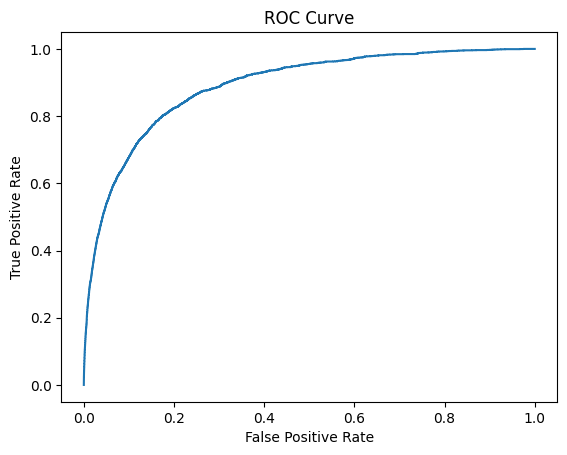

AUC: 0.889872570192476

At FPR: 1.0% 
TPR: 25.569999999999997% 
Threshold: 0.67
Predictive Equality: 99.49%

At FPR: 5.0% 
TPR: 53.93% 
Threshold: 0.38
Predictive Equality: 99.71%


In [7]:
# Evaluate model
predictions = model.predict_proba(X_test)[:,1]

# Add real_customer_age to test dataframe
test["real_customer_age"] = df["customer_age"]
evaluate(predictions)